# Determining the Right Dask Cluster Parameters

## Learning Objectives

In this tutorial, we will:
* Show how to configure clusters based on the memory demands of larger data partitions
* Show how to find larger data partitions
* Discuss general strategies for scaling in-memory code to large out-of-memory runs


## Introduction

Working at scale almost always demands that you, the user, understand details of your workflows memory usage to properly setup the various parameters of your cluster setup. This can also be a very challenging task, as many users are not used to being aware of how much memory their code needs to execute. In this tutorial, we'll walk through a few strategies for determining how much memory your workers will need in the "worst case" and try to equip you with some code and hueristics for how to think about setting up a cluster for your workflow.

In [1]:
import lsdb
import light_curve as licu
from nested_pandas.utils import count_nested
import numpy as np

We'll first begin by opening a catalog (ZTF DR22), with a small cone picked out:

,objectid,filterid,fieldid,rcid,objra,objdec,nepochs,Norder,Dir,Npix,lc
npartitions=25,,,,,,,,,,,
"Order: 5, Pixel: 6092",int64[pyarrow],int8[pyarrow],int16[pyarrow],int8[pyarrow],float[pyarrow],float[pyarrow],int64[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow],"nested<hmjd: [double], mag: [float], magerr: [..."
"Order: 5, Pixel: 6093",...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
"Order: 6, Pixel: 24523",...,...,...,...,...,...,...,...,...,...,...
"Order: 5, Pixel: 6131",...,...,...,...,...,...,...,...,...,...,...


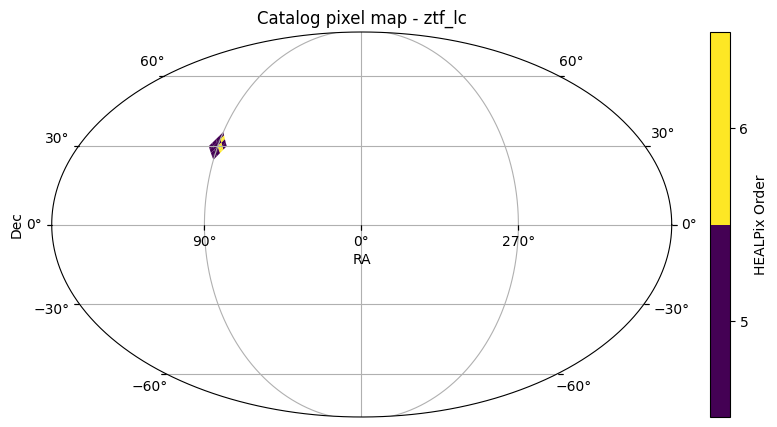

In [2]:
ztf_cat = lsdb.open_catalog(
    "https://data.lsdb.io/hats/ztf_dr22/ztf_lc",
    margin_cache="https://data.lsdb.io/hats/ztf_dr22/ztf_lc_10arcs",
    search_filter=lsdb.ConeSearch(ra=90, dec=30.0, radius_arcsec=11000.0),
)
ztf_cat = ztf_cat.nest_lists(list_columns=["hmjd", "mag", "magerr", "clrcoeff", "catflags"], name="lc")
ztf_cat.plot_pixels()
ztf_cat

Finding the largest pixel can be really helpful setting our cluster up for success, as it will usually be the most challenging partition for a worker to handle. Below is some code to find the largest partition in our cone by memory usage:

In [3]:
# Find the largest pixel
def mem_pix(df, partition_info=None):
    """Calculate the memory usage of a pixel"""
    return df.memory_usage().sum()


largest_partition_idx = (
    ztf_cat.map_partitions(mem_pix, meta=(None, np.int64)).compute().reset_index().idxmax()
)

/astro/users/brantd/.conda/envs/lsdb_latest/lib/python3.11/site-packages/lsdb/catalog/dataset/healpix_dataset.py:556: RuntimeWarning: output of the function must be a DataFrame to generate an LSDB `Catalog`. `map_partitions` will return a dask object instead of a Catalog.
  warnings.warn(


In this case, the index of our largest partition is 18:

In [6]:
largest_partition_idx[0]

np.int64(18)

Let's grab it into memory, via `compute`. We can work with this partition locally, as a means to directly develop and test our analysis code.

In [5]:
# Grab a single partition into memory
ztf_single_pix = ztf_cat.partitions[18].compute()
ztf_single_pix

objectid  filterid  fieldid  rcid      objra  \
_healpix_29                                                                 
1724878657564209309  1657212400024524         2     1657    47  90.001427   
1724878657564378139   659201400032017         2      659     3  90.001419   
...                               ...       ...      ...   ...        ...   
1725160129995874672   659105100007685         1      659    16  90.002464   
1725160130891892172   659305100015836         3      659    16  89.995659   

                        objdec  nepochs  Norder  Dir  Npix  \
_healpix_29                                                  
1724878657564209309  30.001747       10       5    0  6128   
1724878657564378139   30.00177      113       5    0  6128   
...                        ...      ...     ...  ...   ...   
1725160129995874672  32.792778      402       5    0  6128   
1725160130891892172  32.792397        2       5    0  6128   

                                                                    lc  
_healpix_29                                                             
1724878657564209309  [{hmjd: 58429.34964, mag: 21.427361, magerr: 0...  
1724878657564378139  [{hmjd: 58344.4718, mag: 20.900873, magerr: 0....  
...                                                                ...  
1725160129995874672  [{hmjd: 58204.12799, mag: 17.702541, magerr: 0...  
1725160130891892172  [{hmjd: 59170.34582, mag: 21.165676, magerr: 0...  

[870359 rows x 11 columns]

`info` is a nice way to check it's characteristics, we see it's almost 4GBs in memory. While not specifically mentioned in the output, the vast majority of that will be the nested "lc" data. As an initial thought, we know from this that just holding the data will at worst cost 4GBs, meaning that immediately we've discounted having many ~1-2GB workers.

In [6]:
ztf_single_pix.info()

<class 'nested_pandas.nestedframe.core.NestedFrame'>
Index: 870359 entries, 1724878657564209309 to 1725160130891892172
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype                                                                                      
---  ------    --------------   -----                                                                                      
 0   objectid  870359 non-null  int64[pyarrow]                                                                             
 1   filterid  870359 non-null  int8[pyarrow]                                                                              
 2   fieldid   870359 non-null  int16[pyarrow]                                                                             
 3   rcid      870359 non-null  int8[pyarrow]                                                                              
 4   objra     870359 non-null  float[pyarrow]                                                          

Now, let's create an analysis function that calculates the periods for each of our lightcurves:

In [ ]:
def calc_periods(pix_df):
    """Calculate the period of all objects in a pixel"""

    # pix_df is a nested-pandas NestedFrame, so we use the NestedFrame API within this function
    # First, cut our photometry on catflags
    pix_df = pix_df.query("lc.catflags == 0")

    # Drop any empty light curves
    pix_df = pix_df.dropna(subset=["lc"])

    # Now we can calculate the periods
    extractor = licu.Extractor(
        licu.Periodogram(
            peaks=1,
            max_freq_factor=1.0,
            fast=True,
        ),  # Would give two features: peak period and signa-to-noise ratio of the peak
    )

    # light-curve requires all arrays to be the same dtype.
    # It also requires the time array to be ordered and to have no duplicates.
    def _extract_features(mjd, mag, **kwargs):
        # We offset date, so we still would have <1 second precision
        if len(mjd) < 50:
            return dict(zip(extractor.names, [np.nan] * len(extractor.names)))
        t = np.asarray(mjd - 60000, dtype=np.float32)
        # print(t)
        _, sort_index = np.unique(t, return_index=True)
        features = extractor(
            t[sort_index],
            mag[sort_index],
            **kwargs,
        )
        # Return the features as a dictionary
        return dict(zip(extractor.names, features))

    features = pix_df.reduce(
        _extract_features,
        "lc.hmjd",
        "lc.mag",
    )

    return features

It's very useful to test our new analysis function on a single partition of the dataset, and we can easily use the one we just grabbed above. (For larger functions, it's also a great way to iteratively build those functions!)

In [ ]:
# use the computed pixel to test the function
single_res = calc_periods(ztf_single_pix)
single_res

,period_0,period_s_to_n_0
_healpix_29,,
1724878657564209309,NaN,NaN
1724878657564378139,326.805725,6.273389
...,...,...
1725160129995874672,122.629753,6.774995
1725160130891892172,NaN,NaN


We see above that our function works, and what it returns. We see a bunch of nans due to the way we have constructed our function.

Understanding what cluster parameters to use (number of workers, worker memory limits, etc.) can be a very tricky task. Especially when writing a custom function, as we have above, the needs of the cluster will directly depend on the memory demands of our function. Below, we use a memory profiler to estimate the amount of memory used for operating on a single partition. Above, we picked out one of the largest partitions in our sample, which positions this estimate as more of an upper bound to the needed worker memory.

> **IMPORTANT: Memory Profiling Caveats**: It's very easy to use this incorrectly, especially within a notebook environment. Modules like this are almost always measuring the kernel memory, meaning it's not just a measure of the function run, but anything else in memory at the time. If you were to rerun this, you would see the number increasing every time, until garbage collection eventually stepped in. Running the single pixel calculation in the cell above would also affect the result. In principle, this number serves as a reasonable estimate if you restart the kernel and make sure to only run the needed cells ahead of running the memory profiler, and perhaps more ideally you would create a dedicated script executed separately to run the profiler. With these caveats in mind, this is still a useful exercise to get a rough sense of how much memory you will need. 

In [ ]:
# Assessing Memory Usage for a single pixel
from memory_profiler import memory_usage


def calc_periods_mem():
    """Calculate the period of all objects in a pixel, with memory profiling"""

    return calc_periods(ztf_single_pix)


mem = max(
    memory_usage(
        proc=calc_periods_mem,
    )
)
print("Maximum memory used: {} MiB".format(mem))

Maximum memory used: 16769.2421875 MiB


We see that for our largest partition, our analysis required a bit more than 16 GBs of memory. As a rough hueristic, it's good to take this number and multiply it by 1.5-2x when defining memory limits. This overhead is for a couple reasons, dask will be storing intermediate results alongside doing these operations, and the largest partition we found may not be the largest partition in the full dataset. With a smaller number of workers, you might need closer to ~2x as those workers take on more burden in terms of storing intermediate results, whereas with a larger number of workers you might be able to operate comfortably at the ~1.5x regime. From a stability perspective, more worker memory is more reliable, but make sure to at least have a few workers.

Below, we use this information to setup our cluster, allocating 4 workers with 24GBs each. And very importantly, we set this to be single-threaded via `threads_per_worker`, multi-threading can introduce more opportunities for workers to trip up and fail, especially when we're constructing our cluster parameters under the assumption that 1 worker is sized to handle about 1 (large) partition.

In [9]:
# Now we can do this in parallel across all pixels
from dask.distributed import Client

with Client(
    dashboard_address="127.0.0.1:33709", n_workers=4, memory_limit="24GB", threads_per_worker=1
) as client:
    # We can use the map_partitions method to apply our function to each pixel
    # Results from single pixel operations can be used for the meta, but use head(0) to not pass along the full data
    # ztf_cat_prepped = ztf_cat.map_partitions(data_prep, meta=ztf_single_pix_prepped.head(0))
    full_res = ztf_cat.map_partitions(calc_periods, meta=single_res.head(0))
    full_res = full_res.compute()

2025-07-17 10:25:06,199 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 15.72 GiB -- Worker memory limit: 22.35 GiB
2025-07-17 10:25:10,460 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 18.08 GiB -- Worker memory limit: 22.35 GiB
2025-07-17 10:25:10,552 - distributed.worker.memory - WARNING - Worker is at 69% memory usage. Resuming worker. Process memory: 15.49 GiB -- Worker memory limit: 22.35 GiB


Despite our meticulous cluster crafting, we still get some worker memory warnings. These are acceptable, being that we only reach 80% memory at peak, but if you are seeing a lot of these warnings, that may be a sign to up the worker memory, especially for stability of larger jobs.


> **Note**: In this tutorial, we were able to find the "largest" partition in our small cone, and use that to finely constrain our memory limits. However in full datasets it may be prohibitively expensive to find the "largest" partition, in which case adding more worker memory can be very helpful insurance to failing a pipeline run based on one partition just being a touch to large for the cluster setup.

In [8]:
full_res

,period_0,period_s_to_n_0
_healpix_29,,
1715015347870488560,90.381226,3.436837
1715015347870642076,251.193008,3.182266
...,...,...
1725732568560619551,NaN,NaN
1725732574233613000,NaN,NaN


## About
**Authors**: Doug Branton

**Last updated on**: July 17, 2025

If you use lsdb for published research, please cite following [instructions](https://docs.lsdb.io/en/stable/citation.html).